<a href="https://colab.research.google.com/github/jang3463/machinelearning-deeplearning-lecture/blob/main/%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_LSTM%EC%9C%BC%EB%A1%9C_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM으로 네이버 리뷰 분류

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 162kB/s 
     |████████████████████████████████| 460kB 51.2MB/s 
     |████████████████████████████████| 92kB 13.9MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [2]:
# 필요 패키지 import
# 전처리

# 실제 커뮤니티나 사람 처럼 이야기 하게 할 거면 최소한의 전처리만.. (대신에 데이터 양이 상상이상으로 방대해야 함)

# 단순 분루냐 QA 문제라면 전처리가 많이 필요할 수 있다. ( 목적에 맞게 )

import pandas as pd
import numpy as np
import urllib.request

import matplotlib.pyplot as plt
import re

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f38067d7a20>)

In [35]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [36]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [37]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


제대로 해보고 싶으신 분, 도전해 보고 싶으신 분
사이킷 런의 파이프라인을 이용해서 전처리 과정을 관리 해볼수 있도록..

In [38]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 네이버 영화 리뷰 데이터 분석

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [40]:
train_data.document.nunique(), train_data.label.nunique()

(146182, 2)

In [41]:
# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

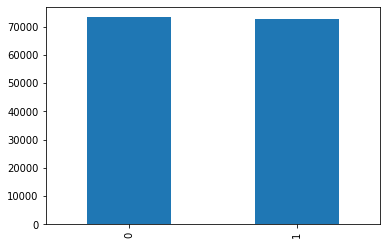

In [42]:
# label의 비율도 확인하자
train_data['label'].value_counts().plot(kind='bar')

In [43]:
# Nan 값 제거
train_data = train_data.dropna(how='any') # Nana값 제거
print(train_data.isnull().values.any())

False


In [44]:
# 정규식으로 정제하기
train_data.document = train_data.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', " ")
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [45]:
# 정규식으로 문자열을 " "로 만들었으니까, 얘도 nan으로 마들엇 ㅓ제거
train_data.document.replace('', np.nan,inplace=True)
train_data = train_data.dropna(how='any')


In [46]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

In [47]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [57]:
# 형태소 분리 후 불용어 처리
# pandas에서 데이터를 하나씩 꺼내와서 형태소 분리 -> 불용어 처리 -> 학습용 데이터의 형식으로 리스트에 저장
from tqdm import tqdm_notebook


okt = Okt()

X_train = []

for sentence in tqdm_notebook(train_data.document):
  temp_X = []
  temp_X = okt.morphs(sentence,stem=True)
  temp_X = [w for w in temp_X if not w in stopwords]
  X_train.append(temp_X)


# 5건만 해보세요

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [58]:
X_test = []

for sentence in tqdm_notebook(test_data.document):
  temp_X = []
  temp_X = okt.morphs(sentence,stem=True)
  temp_X = [w for w in temp_X if not w in stopwords]
  X_test.append(temp_X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## 토크나이저 만들기

In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [60]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '점': 18, '아니다': 19, '않다': 20, '에서': 21, '만들다': 22, '연기': 23, '나오다': 24, '것': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '이렇다': 42, '말': 43, '고': 44, '아깝다': 45, '더': 46, '아': 47, '때': 48, '배우': 49, 'ㅋㅋ': 50, '거': 51, '감독': 52, '그냥': 53, '재미있다': 54, '요': 55, '내용': 56, '시간': 57, '재미': 58, '중': 59, '뭐': 60, '까지': 61, '주다': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '수': 67, '쓰레기': 68, '가다': 69, '네': 70, '모르다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '작품': 75, '지': 76, '사랑': 77, '알다': 78, '다시': 79, '하나': 80, '마지막': 81, '볼': 82, '이건': 83, '오다': 84, 'ㅋ': 85, '정도': 86, '저': 87, '완전': 88, '많다': 89, 'ㅋㅋㅋ': 90, '처음': 91, '장면': 92, '액션': 93, '주인공': 94, '차다': 95, '걸': 96, '이렇게': 97, '안되다': 98, '개': 99, '나다': 100, 'ㅠㅠ': 101, '지금': 

### 너무 빈도수가 적은 단어는 사용하지 않기로..

빈도수가 3 이상인 단어만 사용하기로 함

In [61]:
threshold = 3 # 임계점
total_cnt = len(tokenizer.word_index) # 단어 개수

rare_cnt = 0  # 등장 빈도가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총합

rare_freq = 0 # 등장 빈도수가 threshold 보다 작은 단어의 빈도수의 총합

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if value < threshold:
    rare_cnt +=1 # 희소 단어의 개수
    rare_freq = rare_freq + value

print('단어 집합의 크기 : ', total_cnt)
print('등장 빈도가 2번 이하인 희귀 단어의 수 : ',rare_cnt)
print('단어 집합에서 희귀 단어의 비율 : {:.3f}%'.format((rare_cnt/total_cnt)*100))
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : {:.3f}'.format((rare_freq/total_freq)*100))

단어 집합의 크기 :  43122
등장 빈도가 2번 이하인 희귀 단어의 수 :  23855
단어 집합에서 희귀 단어의 비율 : 55.320%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.839


In [62]:
# vocab_size를 구해보자

vocab_size = total_cnt - rare_cnt +2 # oov,pad 고려해서+2
print(vocab_size)

19269


In [63]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)

정수 인코딩

In [64]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test) # X_train으로 만들어진 토크나이져를 그대로 활용할 것

In [65]:
X_train[:3]

[[48, 455, 17, 264, 660],
 [912, 456, 42, 608, 2, 217, 1451, 24, 960, 680, 21],
 [378, 2441, 1, 5025, 6261, 3, 224, 10]]

In [66]:
X_test[:3]

[[737, 86],
 [61, 160, 27, 432, 21, 19, 296, 851, 47, 784, 20],
 [66, 21, 89, 338, 108, 104, 63, 153, 276]]

In [68]:
# 비어있는 문자열이 들어있는 인덱스 알아내기
drop_train = [ index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_train[:5]

[404, 412, 470, 584, 593]

In [70]:
# label 시리즈도 Numpy 배열로 만들어 주자

y_train = np.array(train_data.label)
y_test = np.array(test_data.label)

In [71]:
# 비어있는 샘플들 삭제
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [73]:
print(len(X_train),len(y_train))

145379 145379


## 패딩 설정하기

In [77]:
# 리뷰 길이에 대한 분포 시각화
print('리뷰의 최대 길이 : ', max(len(i) for i in X_train))
print('리뷰의 평균 길이 : ', sum(map(len, X_train)) / len(X_train))

리뷰의 최대 길이 :  73
리뷰의 평균 길이 :  11.01892983168133


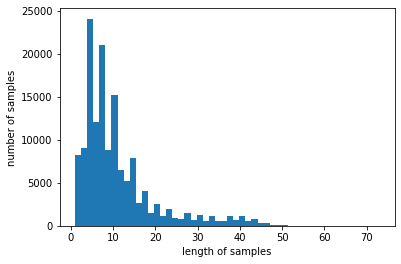

In [78]:
plt.hist([len(s) for s in X_train],bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [79]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if len(s) <= max_len:
      cnt = cnt+1
  print('전체 샘플 중 길이가 {}이하인 샘플의 비율 : {}'.format(max_len, (cnt/len(nested_list)*100)))

패딩은 평균길이의 개념이 아닌, 최대길이 개념 : 임계값으로 삼을 값보다적인 길이의 비유릉ㄹ 확인

In [80]:
below_threshold_len(30 ,X_train)
below_threshold_len(40 ,X_train)
below_threshold_len(50 ,X_train)

전체 샘플 중 길이가 30이하인 샘플의 비율 : 94.06379188190867
전체 샘플 중 길이가 40이하인 샘플의 비율 : 98.06712111102705
전체 샘플 중 길이가 50이하인 샘플의 비율 : 99.90989069948203


In [81]:
# 패딩 적용 : max_len : 30
max_len = 30
X_train = pad_sequences(X_train,maxlen=max_len)
X_test = pad_sequences(X_test,maxlen=max_len)

In [82]:
X_train[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   48,  455,   17,  264,  660],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  912,  456,   42,
         608,    2,  217, 1451,   24,  960,  680,   21],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         378, 2441,    1, 5025, 6261,    3,  224,   10]], dtype=int32)

# LSTM으로 네이버 리뷰 분류

In [83]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [84]:
model = Sequential([
                    Embedding(vocab_size, 100),
                    LSTM(128),
                    Dense(1, activation='sigmoid')
])

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1926900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,044,277
Trainable params: 2,044,277
Non-trainable params: 0
_________________________________________________________________


In [87]:
# 콜백 설정하기
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5',monitor='val_acc',mode='max',verbose=1,save_best_only=True)

In [93]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # 출력층의 유닛이 1개이고 2진 분류를 할 때는 binary_crossentropy를 사용
    metrics=['acc']
)

history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    callbacks=[es,mc],
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
909/909 [==============================] - 31s 23ms/step - loss: 0.4506 - acc: 0.7779 - val_loss: 0.3546 - val_acc: 0.8452

Epoch 00001: val_acc improved from -inf to 0.84520, saving model to best_model.h5
Epoch 2/30
909/909 [==============================] - 20s 22ms/step - loss: 0.3008 - acc: 0.8724 - val_loss: 0.3482 - val_acc: 0.8497

Epoch 00002: val_acc improved from 0.84520 to 0.84970, saving model to best_model.h5
Epoch 3/30
909/909 [==============================] - 19s 21ms/step - loss: 0.2521 - acc: 0.8962 - val_loss: 0.3581 - val_acc: 0.8506

Epoch 00003: val_acc improved from 0.84970 to 0.85060, saving model to best_model.h5
Epoch 4/30
909/909 [==============================] - 19s 21ms/step - loss: 0.2128 - acc: 0.9128 - val_loss: 0.3974 - val_acc: 0.8486

Epoch 00004: val_acc did not improve from 0.85060
Epoch 5/30
909/909 [==============================] - 19s 21ms/step - loss: 0.1753 - acc: 0.9295 - val_loss: 0.4412 - val_acc: 0.8438

Epoch 00005: val_acc di

In [94]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [ word for word in new_sentence if not word in stopwords ] # 불용어 처리
  # 정수 인코딩
  encoded = tokenizer.texts_to_sequences([new_sentence])
  # 패딩
  pad_new = pad_sequences(encoded, maxlen=max_len)
  score = float(model.predict(pad_new))
  if score > 0.5 :
    print("{:.2f}% 확률로 긍정 리뷰 입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰 입니다.".format(( 1 - score ) * 100))

In [96]:
sentiment_predict('노잼')

99.82% 확률로 부정 리뷰 입니다.
